In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import glob
import sys
sys.path.append('/content/drive/My Drive/kaggle/cnn_detection/networks')

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import argparse
import random
import tqdm
import numpy as np
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
from resnet import resnet50
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt

## Hyper-parameters

In [0]:
image_size = 224 #299
batch_size = 64
epoch = 15
n_frames = 10

# training batch02
data_folder = '/content/drive/My Drive/kaggle/batch03'
metadata_dir = glob.glob(os.path.join(data_folder, 'dfdc_train_part_47', '*.json'))[0]
split = 0.8
model_path = '/content/drive/My Drive/kaggle/cnn_detection'

# valset from batch03
data_folder_val = '/content/drive/My Drive/kaggle/batch02'
metadata_dir_val = glob.glob(os.path.join(data_folder_val, 'dfdc_train_part_48', '*.json'))[0]

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else "cpu")
print(device)

cuda


## Prepare Data

Load data from npy files

In [0]:
class VideoDatasetArray(Dataset):
    def __init__(self, root, n_frames, transform=None, train=True):
        """ Intialize the dataset from npy files
        
        Args:
            - root: root directory of the data
            - n_frame: the number of frames for each video
            - tranform: a custom tranform function
            - train: dataset for training
        """
        self.root = root
        self.transform = transform['train' if train else 'val']
        face_dir = os.path.join(self.root)
        if train:
            face_file = glob.glob(os.path.join(face_dir, '*.npy'))
        else:
            face_dir = os.path.join(self.root, 'face10train')
            face_file = [glob.glob(os.path.join(face_dir, '*.npy'))[1]]

        # Preload dataset to memory
        self.labels = []
        self.images = []
        print("\nPreload dataset to memory...\n")
        for face_batch in tqdm.tqdm(face_file, ncols=80):
            data = np.load(face_batch, allow_pickle=True)
            labels = data.item()['y']
            for k in range(len(labels)):
                target = 1 if labels[k] == "FAKE" else 0
                collections = []
                for i in range(10):
                    image = data.item()['x' + str(i)][k].transpose()
                    collections.append(image.copy())
                self.images.append(collections)
                self.labels.append(target)
            # del data
            
        self.len = len(self.labels)
    
    def __getitem__(self, index):
        images = self.images[index]
        label = self.labels[index]
        X = []
        if self.transform is not None:
            for image in images:
                # image = torch.FloatTensor(image)
                x = Image.fromarray(image.astype(np.uint8).transpose(1,2,0))
                X.append(self.transform(x))
        return X, label
    
    def __len__(self):
        return self.len

In [0]:
transform = {
        'train': transforms.Compose([
                    # transforms.ToPILImage(),
                    transforms.Resize(image_size),
                    transforms.RandomHorizontalFlip(),
                    transforms.ColorJitter(hue=0.5),
                    # transforms.RandomRotation(20, resample=Image.BILINEAR),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]), 
        'val': transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
        }

In [0]:
print('----- Load Training Set -------')
trainset = VideoDatasetArray(
    root= data_folder, 
    n_frames = n_frames,
    transform=transform, train=True
)
trainset_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print('----- Load Val Set-------')
valset = VideoDatasetArray(
    root= data_folder_val, 
    n_frames = n_frames,
    transform=transform, train=False
)
valset_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

  0%|                                                    | 0/15 [00:00<?, ?it/s]

----- Load Training Set -------

Preload dataset to memory...



  0%|                                                     | 0/1 [00:00<?, ?it/s]

----- Load Val Set-------

Preload dataset to memory...



100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.00s/it]


In [0]:
print('trainset:', len(trainset))
print('valset:', len(valset))

trainset: 3836
valset: 261


## Utilities for Training

In [0]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name
    
    fine_tuned = [k for k,v in net.named_parameters() if v.requires_grad]
    print('Layer to fine-tune:', fine_tuned)

In [0]:
class MyEnsemble(nn.Module):
    '''
    Ensemble all results from different frames and train the last layer as a classifier.
    '''
    def __init__(self, pretrained, n_frames):
        super(MyEnsemble, self).__init__()
        self.pretrained = pretrained
        self.classifier = nn.Linear(n_frames, 1)
        self.sigmoid = nn.Sigmoid()
        # self.aux = aux

    def forward(self, images):
        X = []
        AUX = []
        for x in images:
            x = self.pretrained(x)
            if isinstance(x, tuple):
                X.append(x[0])
                AUX.append(x[1])
            else:
                X.append(x)
        x = torch.cat(X, dim=1)
        x = self.sigmoid(self.classifier(x))
        if len(AUX) > 0:
            aux = torch.cat(AUX, dim=1) 
            aux = self.sigmoid(self.classifier(aux))
            return x, aux
        return x   

train() and eval() by OOP

In [0]:
class FineTune():
    def __init__(self, model, model_name, epoch, optimizer, filename, log_interval=10):
        self.model = model
        self.model_name = model_name
        self.epoch = epoch
        self.optimizer = optimizer
        self.log_interval = log_interval

        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.output_folder = '/content/drive/My Drive/kaggle/output'
        self.filename = filename

    def train(self):  # set training mode
        loss_fn = nn.BCELoss()
        for ep in range(self.epoch):
            self.model.train()
            iteration = 0
            for batch_idx, (data, target) in enumerate(trainset_loader):
                data = [_data.to(device) for _data in data] 
                target = target.to(device)
                self.optimizer.zero_grad()

                if self.model_name == 'inception':
                    output, aux_output = self.model(data)
                    loss1 = loss_fn(output.squeeze(dim=1), target.type_as(output))
                    loss2 = loss_fn(aux_output.squeeze(dim=1), target.type_as(aux_output))
                    loss = loss1 + 0.4*loss2
                else:
                    output = self.model(data)
                    loss = loss_fn(output.squeeze(dim=1), target.type_as(output))

                loss.backward()
                self.optimizer.step()
                if iteration % self.log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        ep, batch_idx * batch_size, len(trainset_loader.dataset),
                        100. * (batch_idx+1) / len(trainset_loader), loss.item()))
                iteration += 1

            # Evaluation for both the training set and validation set
            self.eval(False)
            self.eval(True)

            history = [self.train_loss, self.train_accuracy, self.val_loss, self.val_accuracy]
            np.save(os.path.join(self.output_folder, self.filename), history)

        # Save loss and accuracy
        output_file = os.path.join(self.output_folder, self.filename+'.txt')

        with open(output_file, 'a') as f:
            f.write('train_loss\n')
            for item in self.train_loss:
                f.write('%s\n' % item)
            f.write('train_accuracy\n')
            for item in self.train_accuracy:
                f.write('%s\n' % item)
            f.write('val_loss\n')
            for item in self.val_loss:
                f.write('%s\n' % item)
            f.write('val_accuracy\n')
            for item in self.val_accuracy:
                f.write('%s\n' % item)

            


    def eval(self, is_val=True):
        loss_fn = nn.BCELoss(reduction="sum")
        self.model.eval()  # set evaluation mode
        loss = 0
        correct = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        data_loader = valset_loader if is_val else trainset_loader
        with torch.no_grad():  # set all requires_grad flags to False
            for data, target in data_loader:
                data = [_data.to(device) for _data in data] 
                target = target.to(device)
                output = self.model(data)
                loss += loss_fn(output.squeeze(dim=1), target.type_as(output)).item()
                pred = (output > 0.5).int()
                correct += pred.eq(target.view_as(pred)).sum().item()

                if is_val:
                    # for calculating precision and recall
                    TP += (pred * target.view_as(pred)).sum().item()
                    TN += ((1 - pred) * (1 - target.view_as(pred))).sum().item()
                    FP += (pred * (1 - target.view_as(pred))).sum().item()
                    FN += ((1 - pred) * target.view_as(pred)).sum().item()

        loss /= len(data_loader.dataset)
        accuracy = 100. * correct / len(data_loader.dataset)

        if is_val:
            # save validation loss and accuracy
            self.val_loss.append(loss)
            self.val_accuracy.append(accuracy)

            # calculate precision, recall, and f1
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            f1 = 2 * precision * recall / (precision + recall)
            print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
                loss, correct, len(data_loader.dataset),
                accuracy, precision, recall, f1))
        else:
            self.train_loss.append(loss)
            self.train_accuracy.append(accuracy)
            print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                loss, correct, len(data_loader.dataset), accuracy))
    
    def plot_loss(self):
        plt.plot(self.train_loss, label='Training loss')
        plt.plot(self.val_loss, label='Validation loss')
        plt.legend(frameon=False)
        plt.show()

    def plot_accuracy(self):
        plt.plot(self.train_accuracy, label='Training accuracy')
        plt.plot(self.val_accuracy, label='Validation accuracy')
        plt.legend(frameon=False)
        plt.show()

## VGG Model

In [0]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


### Training 2-layer classifier baseline

In [0]:
old_classifier = list(vgg16.classifier.children()) 
old_classifier = old_classifier[:3]
print(old_classifier)
old_classifier.append(nn.Linear(4096,1))
vgg16.classifier = nn.Sequential(*old_classifier) 

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [0]:
freeze_until(vgg16, "classifier.3.weight")

Layer to fine-tune: ['classifier.3.weight', 'classifier.3.bias']


In [0]:
del model
model = MyEnsemble(vgg16, n_frames=n_frames)
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=15, optimizer=optimizer, filename='0414_vgg_baseline.txt', log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 0.675229
Train Epoch: 0 [640/3836 (18%)]	Loss: 0.727425
Train Epoch: 0 [1280/3836 (35%)]	Loss: 0.670262
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.647956
Train Epoch: 0 [2560/3836 (68%)]	Loss: 0.613111
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.641076
Train set: Average loss: 0.6084, Accuracy: 2764/3836 (72%)
Val set: Average loss: 0.6827, Accuracy: 147/261 (56%), Precision: 0.5764, Recall: 0.8069, F1: 0.6724
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.583244
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.610238
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.586911
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.544316
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.580717
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.593686
Train set: Average loss: 0.5192, Accuracy: 2925/3836 (76%)
Val set: Average loss: 0.7305, Accuracy: 157/261 (60%), Precision: 0.6228, Recall: 0.7172, F1: 0.6667
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.566149
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.425863
Train Epoch: 2 [1280/

### 2-layer classifier training from scratch

In [0]:
old_classifier = list(vgg16.classifier.children()) 
old_classifier = old_classifier[:3]
print(old_classifier)
old_classifier.append(nn.Linear(4096,1))
vgg16.classifier = nn.Sequential(*old_classifier) 

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [0]:
for k, v in vgg16.named_parameters():
    print(k)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
freeze_until(vgg16, "features.17.weight")

Layer to fine-tune: ['features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias']


In [0]:
# del model
model = MyEnsemble(vgg16, n_frames=n_frames)
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=40, optimizer=optimizer, filename='0417_vgg_scratch_0.0001.txt', log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 0.744805
Train Epoch: 0 [640/3836 (18%)]	Loss: 0.638372
Train Epoch: 0 [1280/3836 (35%)]	Loss: 0.739950
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.698465
Train Epoch: 0 [2560/3836 (68%)]	Loss: 0.704324
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.683829
Train set: Average loss: 0.6746, Accuracy: 2253/3836 (59%)
Val set: Average loss: 0.6923, Accuracy: 137/261 (52%), Precision: 0.5459, Recall: 0.8621, F1: 0.6684
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.704007
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.679114
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.669567
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.683466
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.689079
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.621799
Train set: Average loss: 0.6528, Accuracy: 2424/3836 (63%)
Val set: Average loss: 0.6883, Accuracy: 139/261 (53%), Precision: 0.5481, Recall: 0.9034, F1: 0.6823
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.689346
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.687455
Train Epoch: 2 [1280/

### 2-layer classifier

In [0]:
old_classifier = list(vgg16.classifier.children()) 
old_classifier = old_classifier[:3]
print(old_classifier)
old_classifier.append(nn.Linear(4096,1))
vgg16.classifier = nn.Sequential(*old_classifier) 

freeze_until(vgg16, "features.28.weight")

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]
Layer to fine-tune: ['features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias']


In [0]:
# del model
model = MyEnsemble(vgg16, n_frames=n_frames)
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=15, optimizer=optimizer, log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 0.716189
Train Epoch: 0 [640/3836 (18%)]	Loss: 0.703533
Train Epoch: 0 [1280/3836 (35%)]	Loss: 0.675319
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.620834
Train Epoch: 0 [2560/3836 (68%)]	Loss: 0.648595
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.599282
Train set: Average loss: 0.5902, Accuracy: 2778/3836 (72%)
Val set: Average loss: 0.6574, Accuracy: 160/261 (61%), Precision: 0.6964, Recall: 0.5379, F1: 0.6070
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.550774
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.561930
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.555530
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.552830
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.477664
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.571319
Train set: Average loss: 0.4314, Accuracy: 3096/3836 (81%)
Val set: Average loss: 0.7260, Accuracy: 161/261 (62%), Precision: 0.6552, Recall: 0.6552, F1: 0.6552
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.440473
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.393352
Train Epoch: 2 [1280/

In [0]:
output_folder = '/content/drive/My Drive/kaggle/output'
output_file = os.path.join(output_folder, '0409_vgg_v2.txt')

with open(output_file, 'a') as f:
    f.write('train_loss\n')
    for item in finetune.train_loss:
        f.write('%s\n' % item)
    f.write('train_accuracy\n')
    for item in finetune.train_accuracy:
        f.write('%s\n' % item)
    f.write('val_loss\n')
    for item in finetune.val_loss:
        f.write('%s\n' % item)
    f.write('val_accuracy\n')
    for item in finetune.val_accuracy:
        f.write('%s\n' % item)

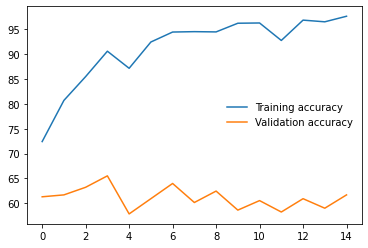

In [0]:
finetune.plot_accuracy()

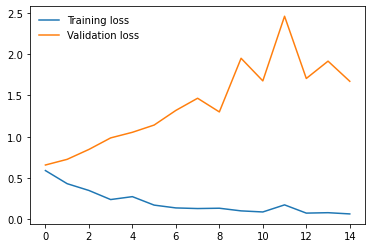

In [0]:
finetune.plot_loss()

In [0]:
torch.save(model.state_dict(), os.path.join(model_path, '0402_vgg_2layer.pth'))

### 1-layer classifer

In [0]:
old_classifier = [nn.Linear(25088,1)]
vgg16.classifier = nn.Sequential(*old_classifier) 

freeze_until(vgg16, "features.28.weight")

Layer to fine-tune: ['features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias']


In [0]:
# del model
model = MyEnsemble(vgg16, n_frames=n_frames)
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=50, optimizer=optimizer, log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 0.692762
Train Epoch: 0 [640/3836 (18%)]	Loss: 0.682810
Train Epoch: 0 [1280/3836 (35%)]	Loss: 0.714087
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.706023
Train Epoch: 0 [2560/3836 (68%)]	Loss: 0.648594
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.707735
Train set: Average loss: 0.6802, Accuracy: 2200/3836 (57%)
Val set: Average loss: 0.6933, Accuracy: 141/261 (54%), Precision: 0.5532, Recall: 0.8966, F1: 0.6842
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.695431
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.661663
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.708673
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.687631
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.647421
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.588928
Train set: Average loss: 0.6044, Accuracy: 2641/3836 (69%)
Val set: Average loss: 0.7106, Accuracy: 127/261 (49%), Precision: 0.5495, Recall: 0.4207, F1: 0.4766
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.586914
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.591347
Train Epoch: 2 [1280/

In [0]:
torch.save(model.state_dict(), os.path.join(model_path, '0404_vgg_1layer.pth'))

## CNN-ResNet Model

In [0]:
# load original model
model_path = '/content/drive/My Drive/kaggle/cnn_detection'
model_file = 'blur_jpg_prob0.1.pth'

resnet = resnet50(num_classes=1)
state_dict = torch.load(os.path.join(model_path, model_file), map_location=device)
resnet.load_state_dict(state_dict['model'])

<All keys matched successfully>

### Baseline

In [0]:
freeze_until(resnet, "fc.weight")

Layer to fine-tune: ['fc.weight', 'fc.bias']


In [0]:
# del model
model = MyEnsemble(resnet, n_frames=n_frames)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=25, optimizer=optimizer, filename='0417_resnet_0.0002_baseline', log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 2.423913
Train Epoch: 0 [640/3836 (18%)]	Loss: 2.523792
Train Epoch: 0 [1280/3836 (35%)]	Loss: 1.985907
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.954043
Train Epoch: 0 [2560/3836 (68%)]	Loss: 1.083990
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.875706
Train set: Average loss: 0.7034, Accuracy: 2221/3836 (58%)
Val set: Average loss: 0.7015, Accuracy: 152/261 (58%), Precision: 0.6011, Recall: 0.7379, F1: 0.6625
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.704461
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.696205
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.669851
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.670897
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.667608
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.705804
Train set: Average loss: 0.6708, Accuracy: 2270/3836 (59%)
Val set: Average loss: 0.6658, Accuracy: 168/261 (64%), Precision: 0.6605, Recall: 0.7379, F1: 0.6971
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.658679
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.765644
Train Epoch: 2 [1280/

### Finetune

In [0]:
freeze_until(resnet, "layer4.0.conv1.weight")

Layer to fine-tune: ['layer4.0.conv1.weight', 'layer4.0.bn1.weight', 'layer4.0.bn1.bias', 'layer4.0.conv2.weight', 'layer4.0.bn2.weight', 'layer4.0.bn2.bias', 'layer4.0.conv3.weight', 'layer4.0.bn3.weight', 'layer4.0.bn3.bias', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.1.conv1.weight', 'layer4.1.bn1.weight', 'layer4.1.bn1.bias', 'layer4.1.conv2.weight', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias', 'layer4.1.conv3.weight', 'layer4.1.bn3.weight', 'layer4.1.bn3.bias', 'layer4.2.conv1.weight', 'layer4.2.bn1.weight', 'layer4.2.bn1.bias', 'layer4.2.conv2.weight', 'layer4.2.bn2.weight', 'layer4.2.bn2.bias', 'layer4.2.conv3.weight', 'layer4.2.bn3.weight', 'layer4.2.bn3.bias', 'fc.weight', 'fc.bias']


In [0]:
del model
model = MyEnsemble(resnet, n_frames=n_frames)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=25, optimizer=optimizer, log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 4.672503
Train Epoch: 0 [640/3836 (18%)]	Loss: 0.835363
Train Epoch: 0 [1280/3836 (35%)]	Loss: 0.746701
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.763925
Train Epoch: 0 [2560/3836 (68%)]	Loss: 0.719150
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.708417
Train set: Average loss: 0.6926, Accuracy: 2095/3836 (55%)
Val set: Average loss: 0.6969, Accuracy: 141/261 (54%), Precision: 0.5494, Recall: 0.9586, F1: 0.6985
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.655747
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.683343
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.698127
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.677461
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.660658
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.731807
Train set: Average loss: 0.6824, Accuracy: 2184/3836 (57%)
Val set: Average loss: 0.6855, Accuracy: 150/261 (57%), Precision: 0.5720, Recall: 0.9310, F1: 0.7087
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.664755
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.674402
Train Epoch: 2 [1280/

In [0]:
output_folder = '/content/drive/My Drive/kaggle/output'
output_file = os.path.join(output_folder, '0410_resnet_v2.txt')

with open(output_file, 'a') as f:
    f.write('train_loss\n')
    for item in finetune.train_loss: 
        f.write('%s\n' % item)
    f.write('train_accuracy\n')
    for item in finetune.train_accuracy:
        f.write('%s\n' % item)
    f.write('val_loss\n')
    for item in finetune.val_loss:
        f.write('%s\n' % item)
    f.write('val_accuracy\n')
    for item in finetune.val_accuracy:
        f.write('%s\n' % item)

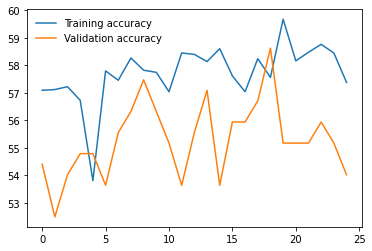

In [0]:
finetune.plot_accuracy()

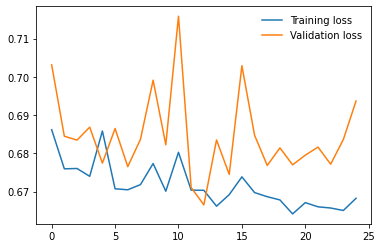

In [0]:
finetune.plot_loss()

## Inception V3 Model
** Note: image size is 299 x 299

In [0]:
inception = models.inception_v3(pretrained=True) 

### Fintune last Conv + Classifier

In [0]:
inception.AuxLogits.fc = nn.Linear(768, 1)
inception.fc = nn.Linear(2048, 1)
freeze_until(inception, "Mixed_7c.branch_pool.conv.weight")

Layer to fine-tune: ['Mixed_7c.branch_pool.conv.weight', 'Mixed_7c.branch_pool.bn.weight', 'Mixed_7c.branch_pool.bn.bias', 'fc.weight', 'fc.bias']


In [0]:
#del model
model = MyEnsemble(inception, n_frames=n_frames) 
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=25, optimizer=optimizer, filename='0415_inception.txt', log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 0.748602
Train Epoch: 0 [640/3836 (18%)]	Loss: 0.701394
Train Epoch: 0 [1280/3836 (35%)]	Loss: 0.684436
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.673303
Train Epoch: 0 [2560/3836 (68%)]	Loss: 0.669448
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.676076
Train set: Average loss: 0.6805, Accuracy: 2100/3836 (55%)
Val set: Average loss: 0.6871, Accuracy: 146/261 (56%), Precision: 0.5591, Recall: 0.9793, F1: 0.7118
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.689981
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.704397
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.666080
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.665212
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.684772
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.670720
Train set: Average loss: 0.6673, Accuracy: 2365/3836 (62%)
Val set: Average loss: 0.6867, Accuracy: 143/261 (55%), Precision: 0.5746, Recall: 0.7172, F1: 0.6380
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.685871
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.675898
Train Epoch: 2 [1280/

In [0]:
torch.save(model.state_dict(), os.path.join(model_path, '0403_inception.pth'))

### Finetune only Classifier

In [0]:
inception.AuxLogits.fc = nn.Linear(768, 1)
inception.fc = nn.Linear(2048, 1)
freeze_until(inception, "fc.weight")

Layer to fine-tune: ['fc.weight', 'fc.bias']


In [0]:
del model
model = MyEnsemble(inception, n_frames=n_frames) 
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
finetune = FineTune(model, 'vgg16', epoch=30, optimizer=optimizer, filename='0416_inception_baseline_0.0002', log_interval=10)
finetune.train()

Train Epoch: 0 [0/3836 (2%)]	Loss: 0.697315
Train Epoch: 0 [640/3836 (18%)]	Loss: 0.682059
Train Epoch: 0 [1280/3836 (35%)]	Loss: 0.698844
Train Epoch: 0 [1920/3836 (52%)]	Loss: 0.690791
Train Epoch: 0 [2560/3836 (68%)]	Loss: 0.684314
Train Epoch: 0 [3200/3836 (85%)]	Loss: 0.682427
Train set: Average loss: 0.6854, Accuracy: 2071/3836 (54%)
Val set: Average loss: 0.6872, Accuracy: 143/261 (55%), Precision: 0.5525, Recall: 0.9793, F1: 0.7065
Train Epoch: 1 [0/3836 (2%)]	Loss: 0.691688
Train Epoch: 1 [640/3836 (18%)]	Loss: 0.689157
Train Epoch: 1 [1280/3836 (35%)]	Loss: 0.688173
Train Epoch: 1 [1920/3836 (52%)]	Loss: 0.683268
Train Epoch: 1 [2560/3836 (68%)]	Loss: 0.710793
Train Epoch: 1 [3200/3836 (85%)]	Loss: 0.686414
Train set: Average loss: 0.6812, Accuracy: 2274/3836 (59%)
Val set: Average loss: 0.6886, Accuracy: 137/261 (52%), Precision: 0.5512, Recall: 0.7793, F1: 0.6457
Train Epoch: 2 [0/3836 (2%)]	Loss: 0.684686
Train Epoch: 2 [640/3836 (18%)]	Loss: 0.698066
Train Epoch: 2 [1280/

In [0]:
torch.save(model.state_dict(), os.path.join(model_path, '0403_inception_clf.pth'))

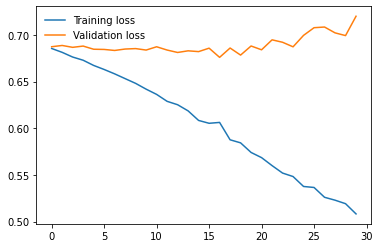

In [0]:
finetune.plot_loss()